# 🧬 Skin Cancer Detection using CNN
Detecting skin cancer using deep learning and image classification . This project focuses on building an end-to-end skin lesion classifier using a Convolutional Neural Network to distinguish between benign and malignant skin lesions.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization,Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
train_dir = "/content/drive/MyDrive/skin_cancer/train"
test_dir = "/content/drive/MyDrive/skin_cancer/test"

### 🔍 Exploring Dataset Structure

To begin with, we inspect the contents of the training and testing directories. Each directory contains subfolders representing the skin cancer classes. This structure allows the image data generators to automatically label the images based on their folder names.

This step is crucial for verifying that the data is organized correctly before feeding it into the deep learning model.


In [ ]:
# List the class folders in the train and test directories
import os
print("Train Classes: ",os.listdir(train_dir))
print("Test Classes: ",os.listdir(test_dir))

Train Classes:  ['Benign', 'Malignant']
Test Classes:  ['Malignant', 'Benign']


### 🧮 Training Data Distribution

Let’s check how many images are available in each class within the training dataset. This helps us understand if the dataset is **balanced or imbalanced**, which can significantly impact model performance — especially in medical diagnosis tasks like skin cancer detection.

Below, we print the number of images for each category (`Benign` vs `Malignant`).


In [ ]:
import os
for category in os.listdir(train_dir):
  print(category,len(os.listdir(os.path.join(train_dir,category))))

Benign 6289
Malignant 5590


In [ ]:
categories = []
image_counts = []
for category in os.listdir(train_dir):
  categories.append(category)
  image_counts.append(len(os.listdir(os.path.join(train_dir,category))))

print("Summary")
print(list(zip(categories, image_counts)))

Summary
[('Benign', 6289), ('Malignant', 5590)]


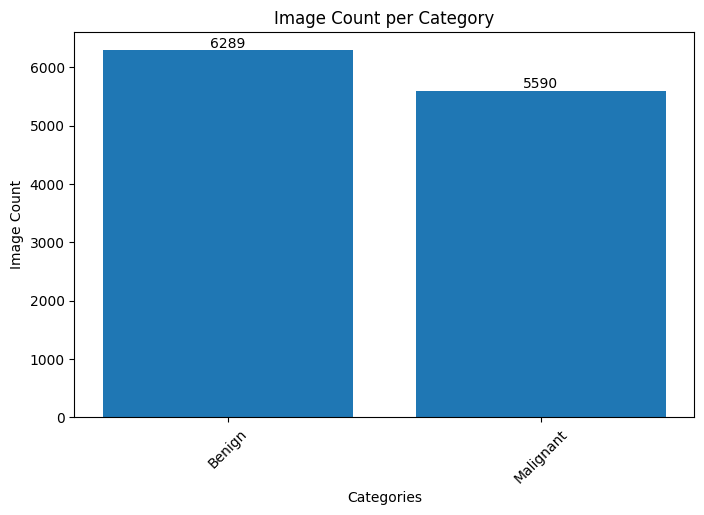

In [ ]:
plt.figure(figsize=(8,5))
ax = plt.bar(categories,image_counts)
ax = plt.gca()
for container in ax.containers:
  ax.bar_label(container)

plt.xlabel("Categories")
plt.ylabel("Image Count")
plt.title("Image Count per Category")
plt.xticks(rotation=45)
plt.show()


➡️ **Observation**:
- `Benign`: 6,289 images  
- `Malignant`: 5,590 images

Although the dataset is relatively balanced, a minor difference exists — this could introduce a **bias during training**, especially in medical applications where **false negatives can be critical**. We'll explore techniques like **class weights**, **data augmentation**, or **oversampling** later in the pipeline to mitigate any imbalance effects.


### 🧪 Data Preprocessing & Augmentation

Medical image datasets often suffer from **limited data availability**, which can lead to overfitting. To overcome this, we apply **data augmentation techniques** to artificially expand the training dataset and introduce variety. This helps the model generalize better on unseen data.

We also rescale pixel values to the [0, 1] range to normalize the input data, which speeds up convergence during training.

Below is the configuration used for both training and testing sets:


In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'

)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (128,128),
    batch_size = 32,
    class_mode = 'binary'
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (128,128),
    batch_size = 32,
    class_mode = 'binary'
)

# Class Labels
print("Class Labels: ",train_generator.class_indices)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Class Labels:  {'Benign': 0, 'Malignant': 1}


➡️ **Why Data Augmentation?**
- Helps prevent **overfitting** by making the model see slightly different versions of the same images.
- Improves **robustness** in real-world scenarios, especially when image conditions (like lighting, position, or scale) vary.
- Essential when working with **medical datasets**, where data collection is expensive and limited.

✅ **Class Labels Mapping**:
```python
{'benign': 0, 'malignant': 1}


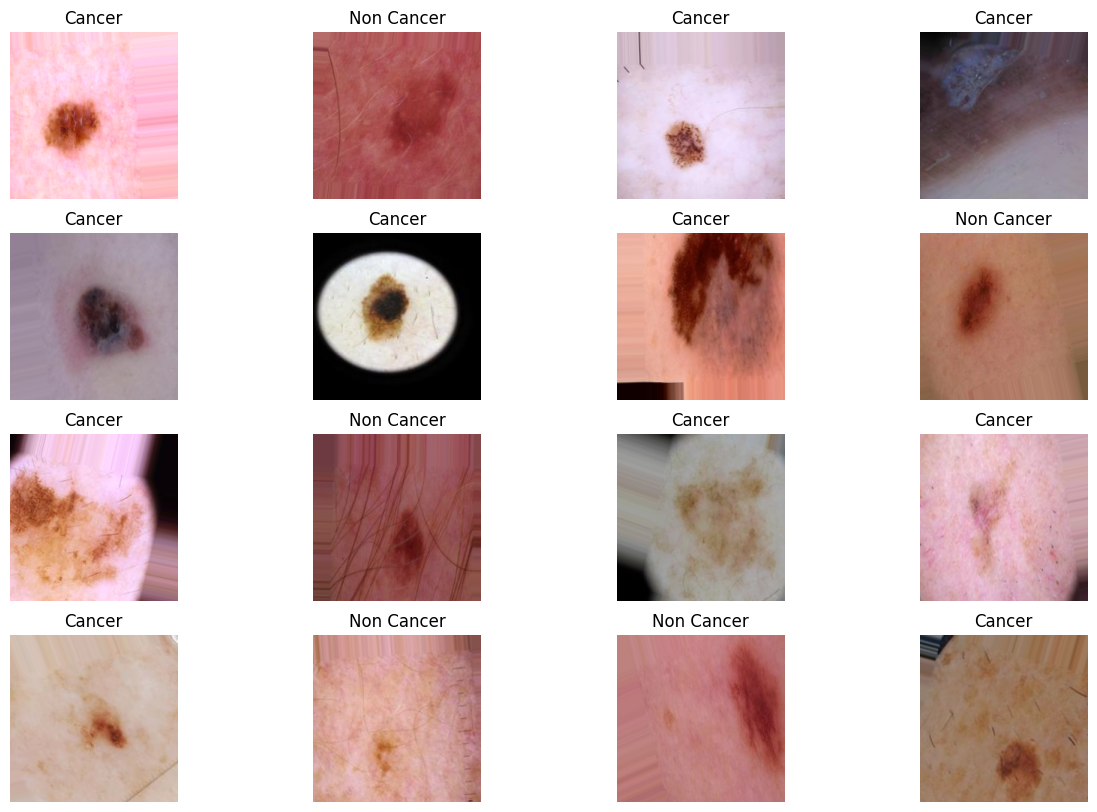

In [ ]:
def plot_images(generator):
  images,labels = next(generator)
  plt.figure(figsize=(15,10))
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i])
    plt.axis("off")
    plt.title("Cancer" if labels[i]==1 else "Non Cancer")


plot_images(train_generator)

### 🧠 Transfer Learning with VGG16

medical imaging tasks typically require a deep understanding of complex patterns (which takes a lot of data to learn from scratch), I leveraged **transfer learning** using the pre-trained **VGG16** model (trained on ImageNet).

VGG16 is known for its strong feature extraction capabilities, which work well even for medical datasets like dermoscopy images.

- I used the VGG16 base as a **fixed feature extractor** (by freezing its layers).
- Added a custom **dense classifier** on top for binary classification: Benign vs Malignant.


In [ ]:
base_model = VGG16(weights='imagenet',include_top=False,input_shape=(128,128,3))

# Freeze the layers
for layer in base_model.layers:
  layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')

])

model.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,560,769 (105.14 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

history = model.fit(train_generator,validation_data=test_generator,epochs=20,callbacks=[early_stopping,lr_scheduler])

Epoch 1/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 9423s 25s/step - accuracy: 0.7389 - loss: 0.9705 - val_accuracy: 0.7970 - val_loss: 0.4175 - learning_rate: 0.0010
Epoch 2/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 230s 618ms/step - accuracy: 0.8254 - loss: 0.3785 - val_accuracy: 0.8050 - val_loss: 0.4114 - learning_rate: 0.0010
Epoch 3/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 225s 605ms/step - accuracy: 0.8402 - loss: 0.3551 - val_accuracy: 0.8640 - val_loss: 0.3109 - learning_rate: 0.0010
Epoch 4/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 231s 622ms/step - accuracy: 0.8400 - loss: 0.3558 - val_accuracy: 0.8250 - val_loss: 0.3771 - learning_rate: 0.0010
Epoch 5/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 230s 618ms/step - accuracy: 0.8488 - loss: 0.3426 - val_accuracy: 0.8390 - val_loss: 0.3501 - learning_rate: 0.0010
Epoch 6/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 228s 612ms/step - accuracy: 0.8393 - loss: 0.3473 - val_accuracy: 0.8795 - val_loss: 0.3057 - learning_rate: 0.0010
Epoch 7/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 226s 607ms/step - accurac

In [ ]:
from tensorflow.keras.applications import EfficientNetB3
base_model = EfficientNetB3(weights='imagenet',include_top=False,input_shape=(128,128,3))

# Freeze the layers
for layer in base_model.layers[-30:]:
  layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')

])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 75264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     9,633,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,426,544 (77.92 MB)

 Trainable params: 16,784,687 (64.03 MB)

 Non-trainable params: 3,641,857 (13.89 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7,min_delta=0.001,restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.2, verbose=1)

history = model.fit(train_generator,validation_data=test_generator,epochs=10,callbacks=[early_stopping,lr_scheduler])

Epoch 1/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 5487s 14s/step - accuracy: 0.8252 - loss: 0.4003 - val_accuracy: 0.5000 - val_loss: 1.6084 - learning_rate: 0.0010
Epoch 2/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 210s 564ms/step - accuracy: 0.8620 - loss: 0.3179 - val_accuracy: 0.5000 - val_loss: 1.3043 - learning_rate: 0.0010
Epoch 3/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 258s 554ms/step - accuracy: 0.8822 - loss: 0.2831 - val_accuracy: 0.3885 - val_loss: 14.5497 - learning_rate: 0.0010
Epoch 4/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 209s 561ms/step - accuracy: 0.8872 - loss: 0.2635 - val_accuracy: 0.5000 - val_loss: 0.9718 - learning_rate: 0.0010
Epoch 5/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 208s 559ms/step - accuracy: 0.8898 - loss: 0.2649 - val_accuracy: 0.4925 - val_loss: 0.9500 - learning_rate: 0.0010
Epoch 6/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 209s 561ms/step - accuracy: 0.9004 - loss: 0.2434 - val_accuracy: 0.5000 - val_loss: 0.9751 - learning_rate: 0.0010
Epoch 7/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 262s 561ms/step - accura

# Model 2: Transfer Learning with EfficientNetB3
# ----------------------------------------------
# - Used EfficientNetB3 as base model (pre-trained on ImageNet)
# - Removed top layer (include_top=False)
# - Input image size: 128x128x3
# - Froze last 30 layers to keep pre-learned features

# - Added custom layers:
#   -> Flatten
#   -> Dense(128) + ReLU + BatchNorm + Dropout(0.3)
#   -> Dense(64) + ReLU + BatchNorm + Dropout(0.3)
#   -> Output: Dense(1) with sigmoid (for binary classification)

# - Compiled with:
#   -> Adam optimizer (lr=0.001)
#   -> Loss: Binary crossentropy
#   -> Metric: Accuracy

# - Used EarlyStopping and ReduceLROnPlateau for better training control

# Training result:
# - Training accuracy improved to ~90%
# - Validation accuracy was unstable (overfitting observed)
# - Need to try: data augmentation, fine-tuning more layers, or using GlobalAveragePooling


## Transfer Learning ResNet50

In [ ]:
base_model = ResNet50(weights='imagenet',include_top=False,input_shape=(128,128,3))

# Freeze the layers
for layer in base_model.layers[-50:]:
  layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')

])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,497,025 (154.48 MB)

 Trainable params: 23,493,377 (89.62 MB)

 Non-trainable params: 17,003,648 (64.86 MB)

In [ ]:
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint

# Balancing the class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

# Save the best model based on validation loss
checkpoint = ModelCheckpoint('best_model.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=7, factor=0.5, verbose=1)

history = model.fit(train_generator,validation_data=test_generator,epochs=20,callbacks=[early_stopping,lr_scheduler,checkpoint],class_weight=class_weights)

Epoch 1/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8096 - loss: 0.4874
Epoch 1: val_loss improved from inf to 1.76678, saving model to best_model.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 2884s 8s/step - accuracy: 0.8097 - loss: 0.4871 - val_accuracy: 0.5115 - val_loss: 1.7668 - learning_rate: 1.0000e-04
Epoch 2/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.8908 - loss: 0.2592
Epoch 2: val_loss improved from 1.76678 to 0.74338, saving model to best_model.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 98s 264ms/step - accuracy: 0.8908 - loss: 0.2592 - val_accuracy: 0.5315 - val_loss: 0.7434 - learning_rate: 1.0000e-04
Epoch 3/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.8993 - loss: 0.2365
Epoch 3: val_loss improved from 0.74338 to 0.38027, saving model to best_model.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 99s 267ms/step - accuracy: 0.8993 - loss: 0.2365 - val_accuracy: 0.8070 - val_loss: 0.3803 - learning_rate: 1.0000e-04
Epoch 4/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9044 - loss: 0.2271
Epoch 4: val_loss improved from 0.38027 to 0.21893, saving model to best_model.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 103s 274ms/step - accuracy: 0.9044 - loss: 0.2271 - val_accuracy: 0.9185 - val_loss: 0.2189 - learning_rate: 1.0000e-04
Epoch 5/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9086 - loss: 0.2247
Epoch 5: val_loss did not improve from 0.21893
372/372 ━━━━━━━━━━━━━━━━━━━━ 98s 260ms/step - accuracy: 0.9086 - loss: 0.2246 - val_accuracy: 0.8800 - val_loss: 0.2693 - learning_rate: 1.0000e-04
Epoch 6/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9172 - loss: 0.2031
Epoch 6: val_loss did not improve from 0.21893
372/372 ━━━━━━━━━━━━━━━━━━━━ 97s 261ms/step - accuracy: 0.9172 - loss: 0.2031 - val_accuracy: 0.8725 - val_loss: 0.2837 - learning_rate: 1.0000e-04
Epoch 7/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9213 - loss: 0.1959
Epoch 7: val_loss improved from 0.21893 to 0.18541, saving model to best_model.h5


372/372 ━━━━━━━━━━━━━━━━━━━━ 98s 262ms/step - accuracy: 0.9213 - loss: 0.1959 - val_accuracy: 0.9315 - val_loss: 0.1854 - learning_rate: 1.0000e-04
Epoch 8/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9223 - loss: 0.1951
Epoch 8: val_loss did not improve from 0.18541
372/372 ━━━━━━━━━━━━━━━━━━━━ 97s 261ms/step - accuracy: 0.9223 - loss: 0.1951 - val_accuracy: 0.9280 - val_loss: 0.1912 - learning_rate: 1.0000e-04
Epoch 9/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9242 - loss: 0.1859
Epoch 9: val_loss did not improve from 0.18541
372/372 ━━━━━━━━━━━━━━━━━━━━ 96s 257ms/step - accuracy: 0.9242 - loss: 0.1859 - val_accuracy: 0.8910 - val_loss: 0.2449 - learning_rate: 1.0000e-04
Epoch 10/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9215 - loss: 0.1857
Epoch 10: val_loss did not improve from 0.18541
372/372 ━━━━━━━━━━━━━━━━━━━━ 96s 259ms/step - accuracy: 0.9215 - loss: 0.1857 - val_accuracy: 0.9205 - val_loss: 0.2048 - learning_rate: 1.0000e-04
E

## Model Training Observations

1. **Accuracy improvement**: The accuracy improved steadily from 80.96% in Epoch 1 to 93.61% in Epoch 12.
2. **Validation loss**: The validation loss decreased significantly in the early epochs but plateaued after Epoch 7.
3. **Validation accuracy**: The validation accuracy increased initially, reaching up to 93.15%, and then fluctuated between 88% and 93%.
4. **Best model saved**: The best model was saved at Epoch 4, where the validation loss was lowest (0.21893).
5. **Training stabilization**: After Epoch 7, the model's training stabilized with no significant improvements in validation loss or accuracy.


In [ ]:
from google.colab import files
files.download('best_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>